# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


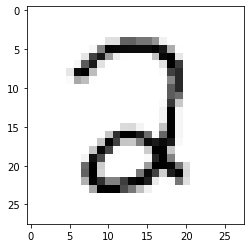

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2518
Training Accuracy: 0.5468, Testing Accuracy: 0.5358



Epoch 10, Loss 0.0948
Training Accuracy: 0.9148, Testing Accuracy: 0.9269



Epoch 20, Loss 0.0569
Training Accuracy: 0.9399, Testing Accuracy: 0.9501



Epoch 30, Loss 0.0449
Training Accuracy: 0.9510, Testing Accuracy: 0.9592



Epoch 40, Loss 0.0388
Training Accuracy: 0.9560, Testing Accuracy: 0.9632



Epoch 50, Loss 0.0351
Training Accuracy: 0.9602, Testing Accuracy: 0.9657



Epoch 60, Loss 0.0325
Training Accuracy: 0.9629, Testing Accuracy: 0.9672



Epoch 70, Loss 0.0306
Training Accuracy: 0.9650, Testing Accuracy: 0.9682



Epoch 80, Loss 0.029
Training Accuracy: 0.9666, Testing Accuracy: 0.9708



Epoch 90, Loss 0.0277
Training Accuracy: 0.9678, Testing Accuracy: 0.9718



Epoch 100, Loss 0.0266
Training Accuracy: 0.9690, Testing Accuracy: 0.9713



Epoch 110, Loss 0.0257
Training Accuracy: 0.9700, Testing Accuracy: 0.9718



Epoch 120, Loss 0.0248
Training Accuracy: 0.9711, Testing Accuracy: 0.9718



Epoch 130, Loss 0.024
Training Accuracy: 0.9724, Testing Accuracy: 0.9728



Epoch 140, Loss 0.0233
Training Accuracy: 0.9729, Testing Accuracy: 0.9728



Epoch 150, Loss 0.0226
Training Accuracy: 0.9738, Testing Accuracy: 0.9743



Epoch 160, Loss 0.022
Training Accuracy: 0.9747, Testing Accuracy: 0.9748



Epoch 170, Loss 0.0214
Training Accuracy: 0.9760, Testing Accuracy: 0.9758



Epoch 180, Loss 0.0209
Training Accuracy: 0.9770, Testing Accuracy: 0.9768



Epoch 190, Loss 0.0204
Training Accuracy: 0.9775, Testing Accuracy: 0.9773



Epoch 200, Loss 0.0199
Training Accuracy: 0.9778, Testing Accuracy: 0.9778



Epoch 210, Loss 0.0194
Training Accuracy: 0.9782, Testing Accuracy: 0.9773



Epoch 220, Loss 0.019
Training Accuracy: 0.9786, Testing Accuracy: 0.9778



Epoch 230, Loss 0.0186
Training Accuracy: 0.9791, Testing Accuracy: 0.9773



Epoch 240, Loss 0.0182
Training Accuracy: 0.9796, Testing Accuracy: 0.9773



0.013063617975919583

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2104
Training Accuracy: 0.7693, Testing Accuracy: 0.7792



Epoch 10, Loss 0.1015
Training Accuracy: 0.9054, Testing Accuracy: 0.9153



Epoch 20, Loss 0.0791
Training Accuracy: 0.9241, Testing Accuracy: 0.9325



Epoch 30, Loss 0.0684
Training Accuracy: 0.9329, Testing Accuracy: 0.9420



Epoch 40, Loss 0.0619
Training Accuracy: 0.9393, Testing Accuracy: 0.9451



Epoch 50, Loss 0.0574
Training Accuracy: 0.9429, Testing Accuracy: 0.9511



Epoch 60, Loss 0.0541
Training Accuracy: 0.9472, Testing Accuracy: 0.9536



Epoch 70, Loss 0.0515
Training Accuracy: 0.9496, Testing Accuracy: 0.9572



Epoch 80, Loss 0.0494
Training Accuracy: 0.9507, Testing Accuracy: 0.9577



Epoch 90, Loss 0.0477
Training Accuracy: 0.9519, Testing Accuracy: 0.9587



Epoch 100, Loss 0.0463
Training Accuracy: 0.9533, Testing Accuracy: 0.9592



Epoch 110, Loss 0.0451
Training Accuracy: 0.9542, Testing Accuracy: 0.9622



Epoch 120, Loss 0.044
Training Accuracy: 0.9555, Testing Accuracy: 0.9632



Epoch 130, Loss 0.043
Training Accuracy: 0.9560, Testing Accuracy: 0.9647



Epoch 140, Loss 0.0422
Training Accuracy: 0.9570, Testing Accuracy: 0.9652



Epoch 150, Loss 0.0414
Training Accuracy: 0.9574, Testing Accuracy: 0.9662



Epoch 160, Loss 0.0408
Training Accuracy: 0.9582, Testing Accuracy: 0.9662



Epoch 170, Loss 0.0401
Training Accuracy: 0.9589, Testing Accuracy: 0.9657



Epoch 180, Loss 0.0396
Training Accuracy: 0.9592, Testing Accuracy: 0.9657



Epoch 190, Loss 0.039
Training Accuracy: 0.9598, Testing Accuracy: 0.9652



Epoch 200, Loss 0.0386
Training Accuracy: 0.9600, Testing Accuracy: 0.9657



Epoch 210, Loss 0.0381
Training Accuracy: 0.9602, Testing Accuracy: 0.9657



Epoch 220, Loss 0.0377
Training Accuracy: 0.9607, Testing Accuracy: 0.9652



Epoch 230, Loss 0.0373
Training Accuracy: 0.9609, Testing Accuracy: 0.9652



Epoch 240, Loss 0.0369
Training Accuracy: 0.9614, Testing Accuracy: 0.9652



0.01173743668294444

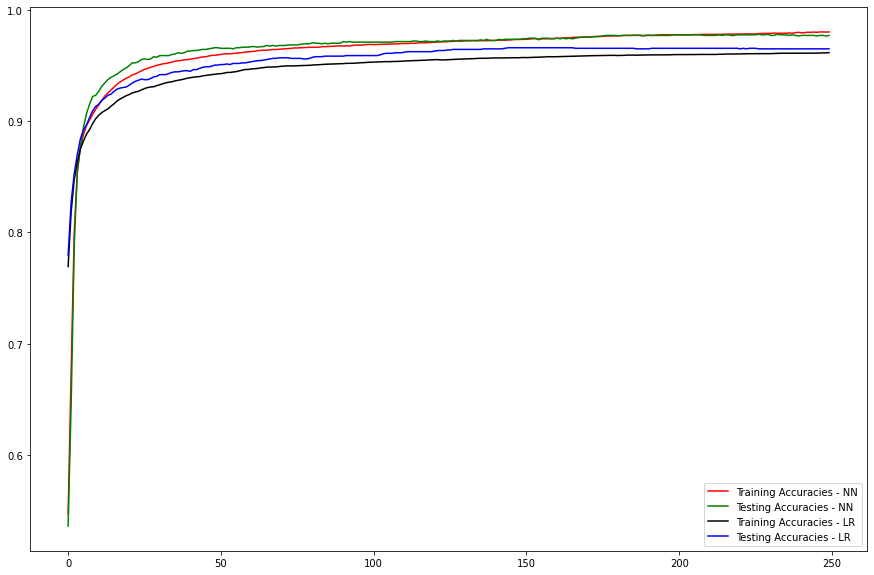

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

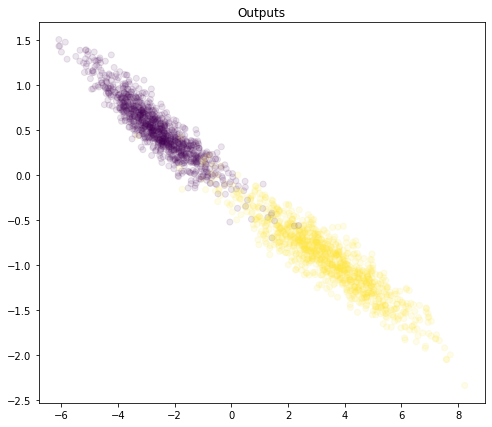

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

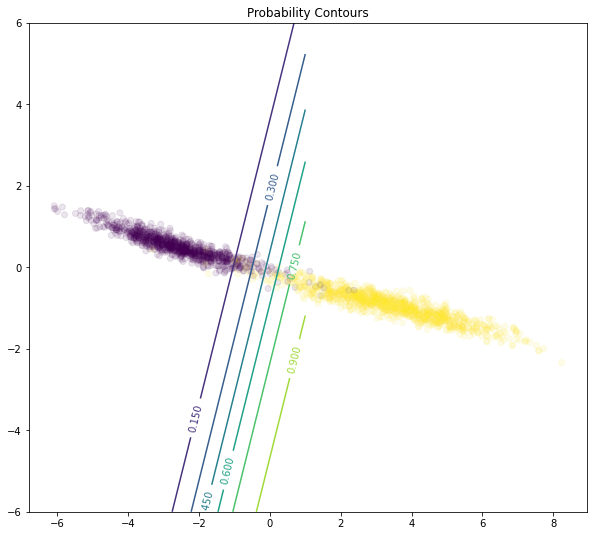

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );